# Human Activity Recognition using HARTH dataset
The goal of this notebook is to test out Human Activity Recognition (HAR) using a one-dimensional Convolutional Neural Network (CNN), Hybrid NN (CNN + LSTM), and techniques such as windowing and class balancing. Also shown is the importance of class balancing in a neural network's training dataset to avoid overfitting to the highest frequency classes and ensure accurate classification of the least frequent classes.

In [1]:
# File handling
import os

# Basics / Plotting
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from timeit import default_timer as timer

# Machine Learning / Pytorch
import torch
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.utils.data import WeightedRandomSampler

# Project specific functions
import helper_functions as hf

In [66]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


### Removing unwanted "index" column in files

In [4]:
data_directory = 'harth_data'

# Loop through all raw data files
for file_name in os.listdir(data_directory):
    if file_name.endswith(".csv"):
        file_path = os.path.join(data_directory, file_name)
        df = pd.read_csv(file_path)
        if 'index' in df.columns: # Account for files that do not have unwanted 'index' column
            df_cleaned = df.drop(columns = ['index']) # Remove unwanted column
            df_cleaned.to_csv(file_path, index=False) # Save back to original file

## Visualizing Dataset

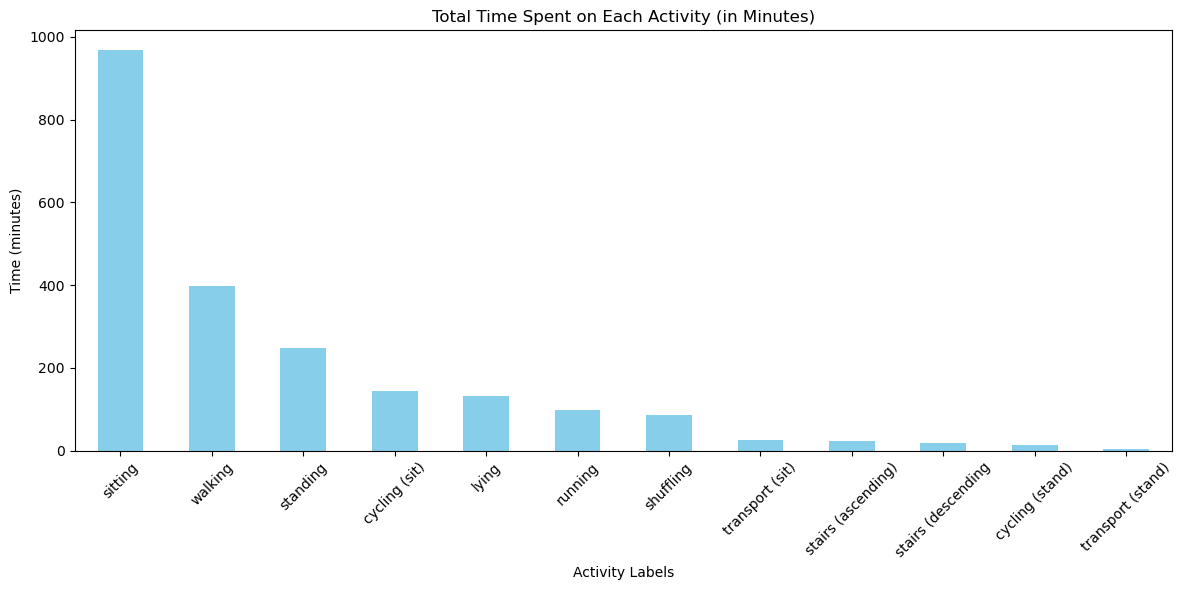

In [67]:
key = {'1':'walking',
       '2':'running',
       '3':'shuffling',
       '4':'transport (sit)',
       '5':'stairs (ascending)',
       '6':'standing',
       '7':'sitting',
       '8':'cycling (sit)',
       '13':'lying',
       '14':'stairs (descending',
       '130':'cycling (stand)',
       '140':'transport (stand)'}

hf.plot_activity_time(data_directory, sampling_rate=50, label_key=key, multiple_files=True)

## Extracting the 6 highest ocurring activities

In [6]:
labels_to_extract = [1, 7, 6, 8, 13, 2]

# Create output directory for data processing
if not os.path.exists('processed_data'):
    os.makedirs('processed_data')

output_directory = 'processed_data'
output_file_name = 'extracted_data.csv'

In [7]:
# Extract most common labels
hf.extract_samples_by_label(data_path=data_directory,
                output_directory=output_directory,
                output_file_name=output_file_name,
                labels=labels_to_extract)

Data extracted and saved to processed_data\extracted_data.csv


## Visualizing new class distribution

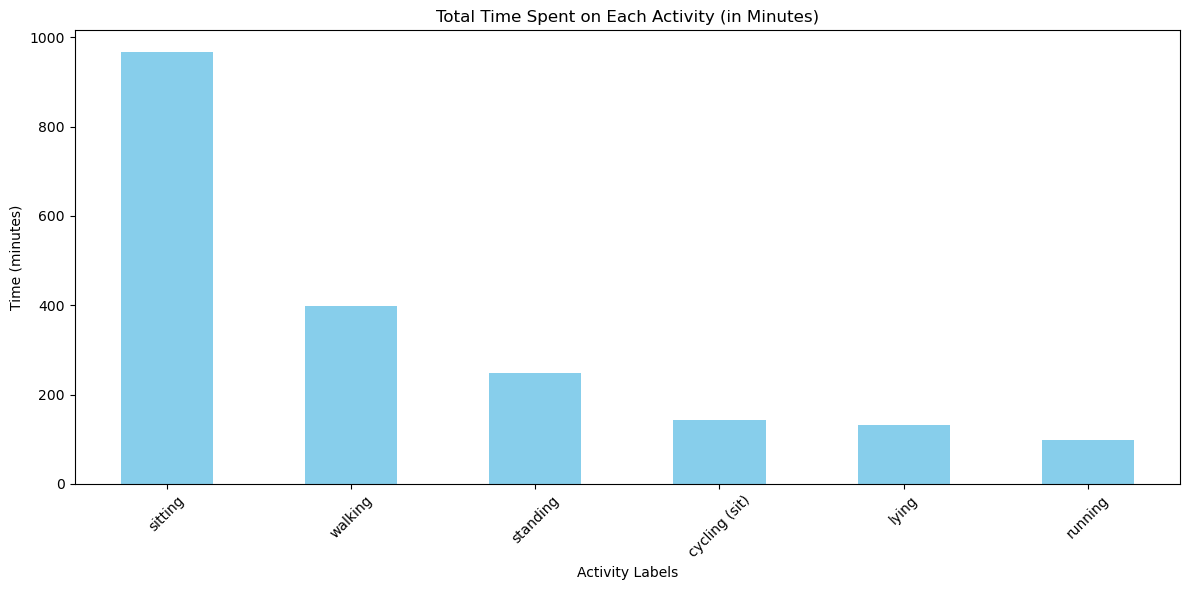

In [8]:
extracted_samples_file = 'processed_data/extracted_data.csv'

key = {'1':'walking',
       '2':'running',
       '6':'standing',
       '7':'sitting',
       '8':'cycling (sit)',
       '13':'lying'}

hf.plot_activity_time(extracted_samples_file, sampling_rate=50, label_key=key, multiple_files=False)

### Relabel classes to 0-5 for proper CNN usage

In [9]:
# Define the mapping from old labels to new labels
relabel_map = {
    1 : 0,
    2 : 1,
    6 : 2,
    7 : 3,
    8 : 4,
    13 : 5
}

# Boolean set up to prevent accidental 2nd relabeling, set to True for initial relabeling
relabel_bool = False
if relabel_bool:
    relabelled_df = hf.relabel_dataset('processed_data/extracted_data.csv', 'processed_data/relabeled_data.csv', relabel_map)

### Window data into one second windows (50 samples) with a half second overlap (25 samples)

In [10]:
# Load in processed data
raw_data = pd.read_csv('processed_data/relabeled_data.csv')

In [11]:
# Create windows and labels with 25-sample overlap
windows, labels = hf.create_windows(raw_data, sequence_length=50, overlap=25)

In [12]:
# Set up df with newly windowed data
windows_df = pd.DataFrame({
    'features': windows,
    'label': labels
})

### Preparing data for Models

In [13]:
# Split the dataset into train, val, and test sets
train_df, temp_df = train_test_split(windows_df, train_size=0.7, stratify=windows_df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

In [14]:
# Shape is not correct for CNN which we can fix later on (should be 6x50 for 6 1D channels)
print(val_df['features'].iloc[0].shape)

(50, 6)


In [15]:
from AccelerometerDataset import AccelerometerDataset

# Create datasets
train_dataset = AccelerometerDataset(train_df)
val_dataset = AccelerometerDataset(val_df)
test_dataset = AccelerometerDataset(test_df)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

### Importing and initializing model

In [16]:
from CNN import HAR_CNN_1D

# Create model instance
model_0 = HAR_CNN_1D().to(device)
next(model_0.parameters()).device

device(type='cuda', index=0)

In [17]:
# Set up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_0.parameters(), lr=0.001)

### Training model

In [18]:
# Lists to store accuracy and loss values for future plotting
scores_model_0 = {'train_loss': [],
          'train_acc': [],
          'test_loss': [],
          'test_acc': []}

# Set early stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0
max_epoch_0 = 0

# Initialize training time
train_time_start = timer()
epochs = 50

for epoch in tqdm(range(epochs)):
    print('Epoch: ', epoch, '\n---------------')
    max_epoch_0 += 1
    # Training step
    hf.train_step(
        model=model_0,
        data_loader=train_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=hf.accuracy_fn,
        device=device,
        scores_storage=scores_model_0
    )

    # Validation step
    val_loss = hf.test_step(
        model=model_0,
        data_loader=val_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=hf.accuracy_fn,
        device=device,
        scores_storage=scores_model_0
    )

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves
        print(f"Validation loss improved to {best_val_loss:.5f}, resetting patience counter.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss. Patience counter: {patience_counter}/{patience}")

    # Check if early stopping condition is met
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# End training time
train_time_end = timer()
total_train_time = train_time_end - train_time_start
print(f"Train time: {total_train_time:.3f} seconds")

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch:  0 
---------------
Train Loss: 0.09710	Train Accuracy: 97.06%


  2%|█▋                                                                                 | 1/50 [00:12<10:03, 12.31s/it]

Test Loss: 0.07365	Test Accuracy: 97.72%
Validation loss improved to 0.07365, resetting patience counter.
Epoch:  1 
---------------
Train Loss: 0.07058	Train Accuracy: 97.87%


  4%|███▎                                                                               | 2/50 [00:24<09:38, 12.05s/it]

Test Loss: 0.06530	Test Accuracy: 97.91%
Validation loss improved to 0.06530, resetting patience counter.
Epoch:  2 
---------------
Train Loss: 0.06466	Train Accuracy: 98.02%


  6%|████▉                                                                              | 3/50 [00:36<09:27, 12.07s/it]

Test Loss: 0.06228	Test Accuracy: 98.06%
Validation loss improved to 0.06228, resetting patience counter.
Epoch:  3 
---------------
Train Loss: 0.06031	Train Accuracy: 98.16%


  8%|██████▋                                                                            | 4/50 [00:48<09:11, 11.99s/it]

Test Loss: 0.05943	Test Accuracy: 98.09%
Validation loss improved to 0.05943, resetting patience counter.
Epoch:  4 
---------------
Train Loss: 0.05675	Train Accuracy: 98.21%


 10%|████████▎                                                                          | 5/50 [01:00<08:59, 11.98s/it]

Test Loss: 0.05934	Test Accuracy: 98.10%
Validation loss improved to 0.05934, resetting patience counter.
Epoch:  5 
---------------
Train Loss: 0.05404	Train Accuracy: 98.27%


 12%|█████████▉                                                                         | 6/50 [01:11<08:45, 11.94s/it]

Test Loss: 0.06197	Test Accuracy: 98.07%
No improvement in validation loss. Patience counter: 1/5
Epoch:  6 
---------------
Train Loss: 0.05089	Train Accuracy: 98.36%


 14%|███████████▌                                                                       | 7/50 [01:23<08:34, 11.96s/it]

Test Loss: 0.05828	Test Accuracy: 98.18%
Validation loss improved to 0.05828, resetting patience counter.
Epoch:  7 
---------------
Train Loss: 0.04817	Train Accuracy: 98.39%


 16%|█████████████▎                                                                     | 8/50 [01:36<08:26, 12.06s/it]

Test Loss: 0.06015	Test Accuracy: 98.15%
No improvement in validation loss. Patience counter: 1/5
Epoch:  8 
---------------
Train Loss: 0.04553	Train Accuracy: 98.48%


 18%|██████████████▉                                                                    | 9/50 [01:48<08:12, 12.02s/it]

Test Loss: 0.05453	Test Accuracy: 98.25%
Validation loss improved to 0.05453, resetting patience counter.
Epoch:  9 
---------------
Train Loss: 0.04323	Train Accuracy: 98.51%


 20%|████████████████▍                                                                 | 10/50 [02:00<07:58, 11.97s/it]

Test Loss: 0.05818	Test Accuracy: 98.18%
No improvement in validation loss. Patience counter: 1/5
Epoch:  10 
---------------
Train Loss: 0.04075	Train Accuracy: 98.61%


 22%|██████████████████                                                                | 11/50 [02:12<07:47, 11.98s/it]

Test Loss: 0.05880	Test Accuracy: 98.21%
No improvement in validation loss. Patience counter: 2/5
Epoch:  11 
---------------
Train Loss: 0.03870	Train Accuracy: 98.66%


 24%|███████████████████▋                                                              | 12/50 [02:23<07:32, 11.90s/it]

Test Loss: 0.06061	Test Accuracy: 98.33%
No improvement in validation loss. Patience counter: 3/5
Epoch:  12 
---------------
Train Loss: 0.03663	Train Accuracy: 98.73%


 26%|█████████████████████▎                                                            | 13/50 [02:35<07:20, 11.92s/it]

Test Loss: 0.06089	Test Accuracy: 98.28%
No improvement in validation loss. Patience counter: 4/5
Epoch:  13 
---------------
Train Loss: 0.03471	Train Accuracy: 98.78%


 26%|█████████████████████▎                                                            | 13/50 [02:47<07:56, 12.88s/it]

Test Loss: 0.06240	Test Accuracy: 98.34%
No improvement in validation loss. Patience counter: 5/5
Early stopping triggered after 14 epochs.
Train time: 167.499 seconds


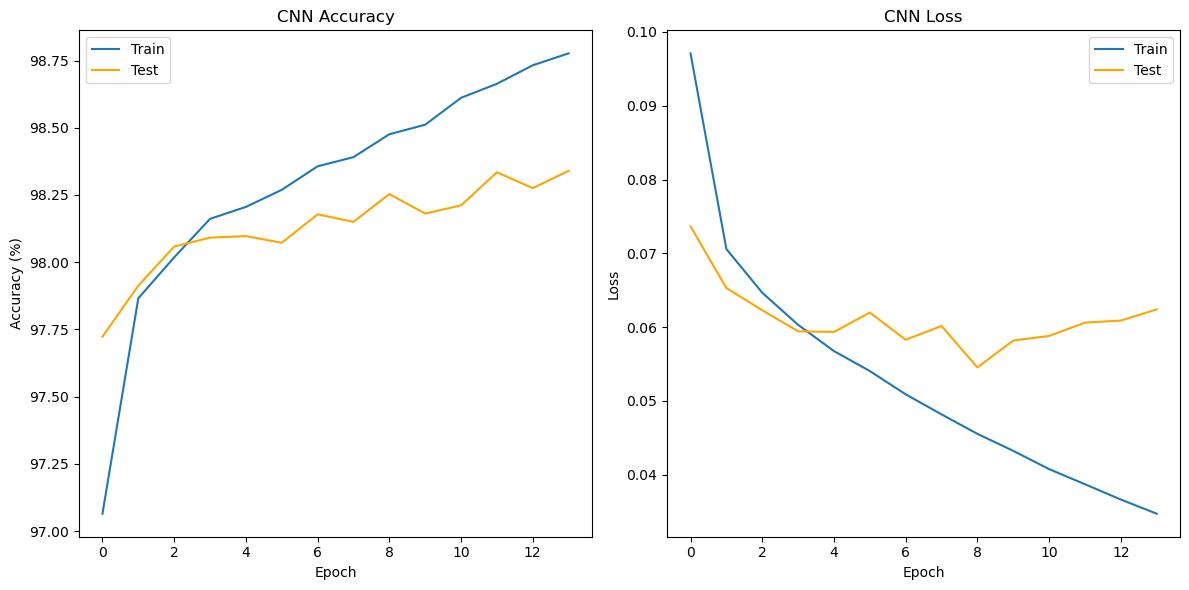

In [25]:
plt.figure(1, clear=True, figsize=[12,6])
plt.subplot(1,2,1)
plt.plot(np.arange(0, max_epoch_0, 1), scores_model_0['train_acc'], label='Train')
plt.plot(np.arange(0, max_epoch_0, 1), scores_model_0['test_acc'], color='orange', label='Test')
plt.title('CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig('Figures/model_0_acc.jpg')

plt.subplot(1,2,2)
plt.plot(np.arange(0, max_epoch_0, 1), scores_model_0['train_loss'], label='Train')
plt.plot(np.arange(0, max_epoch_0, 1), scores_model_0['test_loss'], color='orange', label='Test')
plt.title('CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Figures/model_0_loss.jpg')

plt.tight_layout()

In [26]:
y_preds, y_true = hf.get_preds(model = model_0,
                            data_loader = test_loader,
                            device = device)

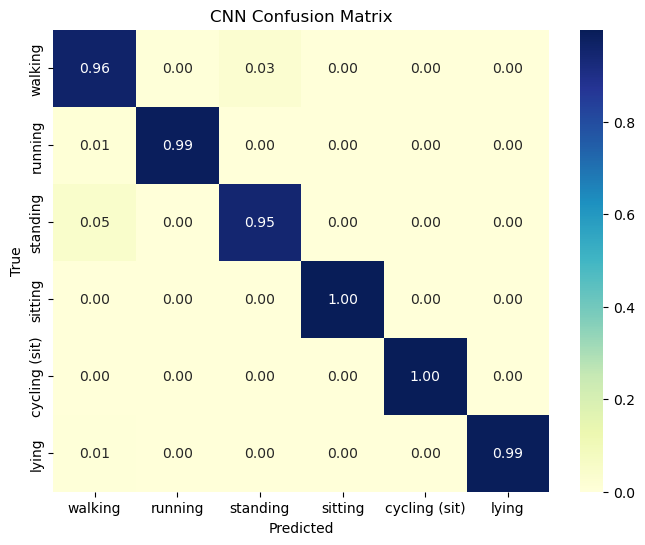

In [27]:
class_names = ['walking', 'running', 'standing', 'sitting', 'cycling (sit)','lying']

# Create confusion matrix
cm = confusion_matrix(y_true, y_preds, normalize='true')

# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('CNN Confusion Matrix')
plt.savefig('Figures/model_0_confm.jpg')

In [28]:
from Hybrid import HAR_Hybrid

# Create model instance
model_1 = HAR_Hybrid().to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [29]:
# Set up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.001)

In [30]:
# Lists to store accuracy and loss values for future plotting
scores_model_1 = {'train_loss': [],
                  'train_acc': [],
                  'test_loss': [],
                  'test_acc': []}

# Set early stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0
max_epoch_1 = 0

# Initialize training time
train_time_start = timer()
epochs = 50

for epoch in tqdm(range(epochs)):
    print('Epoch: ', epoch, '\n---------------')
    max_epoch_1 += 1
    # Training step
    hf.train_step(
        model=model_1,
        data_loader=train_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=hf.accuracy_fn,
        device=device,
        scores_storage=scores_model_1
    )

    # Validation step
    val_loss = hf.test_step(
        model=model_1,
        data_loader=val_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=hf.accuracy_fn,
        device=device,
        scores_storage=scores_model_1
    )

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves
        print(f"Validation loss improved to {best_val_loss:.5f}, resetting patience counter.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss. Patience counter: {patience_counter}/{patience}")

    # Check if early stopping condition is met
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# End training time
train_time_end = timer()
total_train_time = train_time_end - train_time_start
print(f"Train time: {total_train_time:.3f} seconds")

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch:  0 
---------------
Train Loss: 0.12115	Train Accuracy: 96.46%


  2%|█▋                                                                                 | 1/50 [00:15<12:40, 15.51s/it]

Test Loss: 0.07814	Test Accuracy: 97.62%
Validation loss improved to 0.07814, resetting patience counter.
Epoch:  1 
---------------
Train Loss: 0.07830	Train Accuracy: 97.69%


  4%|███▎                                                                               | 2/50 [00:29<11:37, 14.53s/it]

Test Loss: 0.07006	Test Accuracy: 97.88%
Validation loss improved to 0.07006, resetting patience counter.
Epoch:  2 
---------------
Train Loss: 0.06992	Train Accuracy: 97.86%


  6%|████▉                                                                              | 3/50 [00:43<11:12, 14.32s/it]

Test Loss: 0.06996	Test Accuracy: 97.93%
Validation loss improved to 0.06996, resetting patience counter.
Epoch:  3 
---------------
Train Loss: 0.06562	Train Accuracy: 98.01%


  8%|██████▋                                                                            | 4/50 [00:58<11:03, 14.43s/it]

Test Loss: 0.06331	Test Accuracy: 98.08%
Validation loss improved to 0.06331, resetting patience counter.
Epoch:  4 
---------------
Train Loss: 0.06187	Train Accuracy: 98.05%


 10%|████████▎                                                                          | 5/50 [01:12<10:42, 14.27s/it]

Test Loss: 0.06887	Test Accuracy: 97.85%
No improvement in validation loss. Patience counter: 1/5
Epoch:  5 
---------------
Train Loss: 0.05831	Train Accuracy: 98.15%


 12%|█████████▉                                                                         | 6/50 [01:25<10:22, 14.16s/it]

Test Loss: 0.06011	Test Accuracy: 98.15%
Validation loss improved to 0.06011, resetting patience counter.
Epoch:  6 
---------------
Train Loss: 0.05637	Train Accuracy: 98.21%


 14%|███████████▌                                                                       | 7/50 [01:39<10:06, 14.10s/it]

Test Loss: 0.05708	Test Accuracy: 98.26%
Validation loss improved to 0.05708, resetting patience counter.
Epoch:  7 
---------------
Train Loss: 0.05309	Train Accuracy: 98.31%


 16%|█████████████▎                                                                     | 8/50 [01:54<09:52, 14.10s/it]

Test Loss: 0.05743	Test Accuracy: 98.21%
No improvement in validation loss. Patience counter: 1/5
Epoch:  8 
---------------
Train Loss: 0.05086	Train Accuracy: 98.37%


 18%|██████████████▉                                                                    | 9/50 [02:08<09:37, 14.09s/it]

Test Loss: 0.05555	Test Accuracy: 98.26%
Validation loss improved to 0.05555, resetting patience counter.
Epoch:  9 
---------------
Train Loss: 0.04869	Train Accuracy: 98.42%


 20%|████████████████▍                                                                 | 10/50 [02:22<09:21, 14.04s/it]

Test Loss: 0.05378	Test Accuracy: 98.30%
Validation loss improved to 0.05378, resetting patience counter.
Epoch:  10 
---------------
Train Loss: 0.04661	Train Accuracy: 98.46%


 22%|██████████████████                                                                | 11/50 [02:35<09:05, 13.98s/it]

Test Loss: 0.05693	Test Accuracy: 98.33%
No improvement in validation loss. Patience counter: 1/5
Epoch:  11 
---------------
Train Loss: 0.04460	Train Accuracy: 98.52%


 24%|███████████████████▋                                                              | 12/50 [02:49<08:50, 13.96s/it]

Test Loss: 0.05379	Test Accuracy: 98.34%
No improvement in validation loss. Patience counter: 2/5
Epoch:  12 
---------------
Train Loss: 0.04285	Train Accuracy: 98.55%


 26%|█████████████████████▎                                                            | 13/50 [03:03<08:38, 14.02s/it]

Test Loss: 0.05429	Test Accuracy: 98.37%
No improvement in validation loss. Patience counter: 3/5
Epoch:  13 
---------------
Train Loss: 0.04090	Train Accuracy: 98.60%


 28%|██████████████████████▉                                                           | 14/50 [03:17<08:24, 14.00s/it]

Test Loss: 0.05572	Test Accuracy: 98.32%
No improvement in validation loss. Patience counter: 4/5
Epoch:  14 
---------------
Train Loss: 0.03906	Train Accuracy: 98.66%


 28%|██████████████████████▉                                                           | 14/50 [03:31<09:04, 15.14s/it]

Test Loss: 0.06386	Test Accuracy: 98.33%
No improvement in validation loss. Patience counter: 5/5
Early stopping triggered after 15 epochs.
Train time: 211.926 seconds


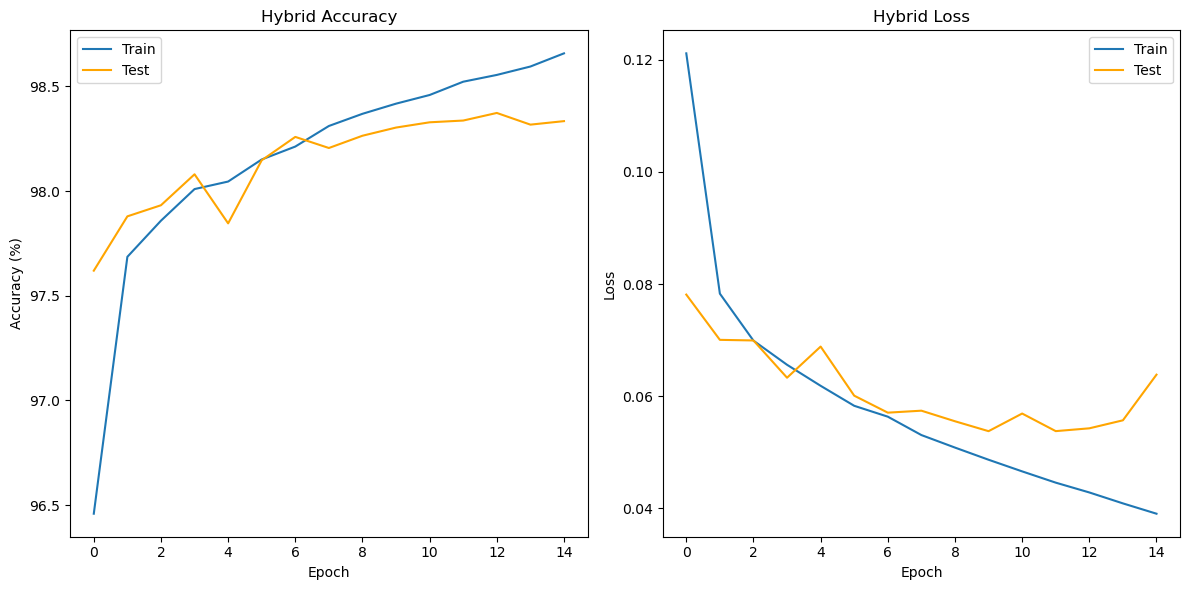

In [31]:
plt.figure(1, clear=True, figsize=[12, 6])

# Convert the accuracy and loss values to NumPy arrays
train_acc = np.array(scores_model_1['train_acc'])
test_acc = np.array(scores_model_1['test_acc'])

# For loss values, ensure they're on CPU before conversion
train_loss = np.array([loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in scores_model_1['train_loss']])
test_loss = np.array([loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in scores_model_1['test_loss']])

plt.subplot(1, 2, 1)
plt.plot(np.arange(0, max_epoch_1, 1), train_acc, label='Train')
plt.plot(np.arange(0,max_epoch_1,1), test_acc, color='orange', label='Test')
plt.title('Hybrid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig('Figures/model_1_acc.jpg')

plt.subplot(1, 2, 2)
plt.plot(np.arange(0, max_epoch_1, 1), train_loss, label='Train')
plt.plot(np.arange(0, max_epoch_1, 1), test_loss, color='orange', label='Test')
plt.title('Hybrid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Figures/model_1_loss.jpg')

plt.tight_layout()
plt.show()


In [32]:
y_preds, y_true = hf.get_preds(model = model_1,
                            data_loader = test_loader,
                            device = device)

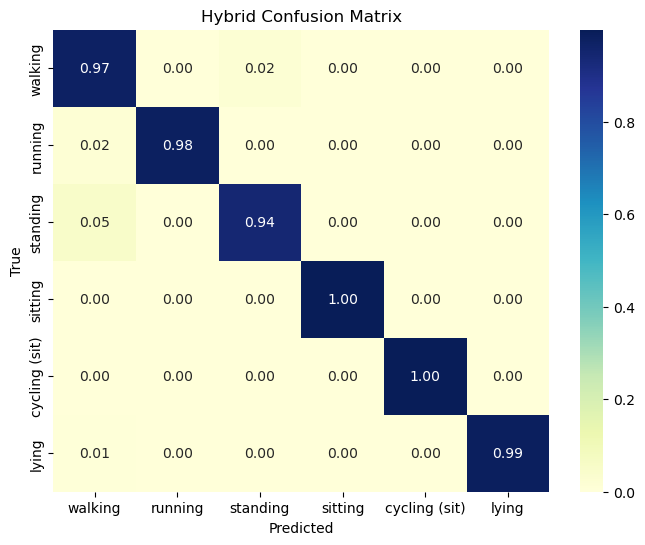

In [38]:
class_names = ['walking', 'running', 'standing', 'sitting', 'cycling (sit)','lying']

# Create confusion matrix
cm = confusion_matrix(y_true, y_preds, normalize='true')

# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Hybrid Confusion Matrix')
plt.savefig('Figures/model_1_confm.jpg')

## Balancing classes and retesting
Due to the nature of loss functions, neural networks are rewarded moreso for accurately predicting classes that appear more frequently in the dataset they are trained on. The inverse of this means that the NN is less inclined to optimize for the classes that appear less frequently in a training dataset. There are multiple methods to correct for this that I will be testing: weighted loss function, weighted random sampler, manual class balancing. Despite the models' already impressive performance on fairly imbalanced classes, any increase in performance is valuable and worth experimenting with. Moving forward, only the Hybrid model architecture will be used as it generalized slightly better than the CNN. (Note: if the confusion matrix showed that the model was disproportionately performing better on the higher frequency classes and worse on the lower frequency classes, then balancing would likely improve model performance. However, in our case, it looks like to model is struggling with the 2nd and 3rd most common classes, so class balancing is not likely to improve performance much, if at all.)

In [34]:
# Find counts for each label
df = pd.read_csv('processed_data/relabeled_data.csv')
label_counts = df['label'].value_counts()
# Re-index to ensure proper order
label_counts = label_counts.sort_index()

# Find count relative to total
label_weights = (1 / label_counts) * 1000000 # multiplying for easier interpretability
print(label_counts)

label
0    1197155
1     291356
2     743480
3    2902703
4     428898
5     393963
Name: count, dtype: int64


### Training model using weighted loss function

In [35]:
model_2 = HAR_Hybrid().to(device)
next(model_2.parameters()).device

device(type='cuda', index=0)

In [36]:
# Create tensor to be used as weights parameter in loss function
loss_weights = torch.tensor(label_weights.values, dtype=torch.float32).to(device)

loss_fn_weighted = nn.CrossEntropyLoss(weight = loss_weights)
optimizer = optim.Adam(model_2.parameters(), lr=0.001)

print(loss_weights)

tensor([0.8353, 3.4322, 1.3450, 0.3445, 2.3316, 2.5383], device='cuda:0')


In [37]:
# Lists to store accuracy and loss values for future plotting
scores_model_2 = {'train_loss': [],
                  'train_acc': [],
                  'test_loss': [],
                  'test_acc': []}

# Set early stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0
max_epoch_2 = 0

# Initialize training time
train_time_start = timer()
epochs = 50

for epoch in tqdm(range(epochs)):
    print('Epoch: ', epoch, '\n---------------')
    max_epoch_2 += 1
    # Training step
    hf.train_step(
        model=model_2,
        data_loader=train_loader,
        loss_fn=loss_fn_weighted,
        optimizer=optimizer,
        accuracy_fn=hf.accuracy_fn,
        device=device,
        scores_storage=scores_model_2
    )

    # Validation step
    val_loss = hf.test_step(
        model=model_2,
        data_loader=val_loader,
        loss_fn=loss_fn_weighted,
        optimizer=optimizer,
        accuracy_fn=hf.accuracy_fn,
        device=device,
        scores_storage=scores_model_2
    )

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves
        print(f"Validation loss improved to {best_val_loss:.5f}, resetting patience counter.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss. Patience counter: {patience_counter}/{patience}")

    # Check if early stopping condition is met
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# End training time
train_time_end = timer()
total_train_time = train_time_end - train_time_start
print(f"Train time: {total_train_time:.3f} seconds")

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch:  0 
---------------
Train Loss: 0.14277	Train Accuracy: 96.23%


  2%|█▋                                                                                 | 1/50 [00:15<13:00, 15.93s/it]

Test Loss: 0.09048	Test Accuracy: 97.51%
Validation loss improved to 0.09048, resetting patience counter.
Epoch:  1 
---------------
Train Loss: 0.09065	Train Accuracy: 97.45%


  4%|███▎                                                                               | 2/50 [00:30<11:53, 14.85s/it]

Test Loss: 0.08078	Test Accuracy: 97.92%
Validation loss improved to 0.08078, resetting patience counter.
Epoch:  2 
---------------
Train Loss: 0.07931	Train Accuracy: 97.73%


  6%|████▉                                                                              | 3/50 [00:44<11:22, 14.52s/it]

Test Loss: 0.07187	Test Accuracy: 98.06%
Validation loss improved to 0.07187, resetting patience counter.
Epoch:  3 
---------------
Train Loss: 0.07440	Train Accuracy: 97.85%


  8%|██████▋                                                                            | 4/50 [00:58<11:05, 14.47s/it]

Test Loss: 0.07899	Test Accuracy: 97.95%
No improvement in validation loss. Patience counter: 1/5
Epoch:  4 
---------------
Train Loss: 0.06984	Train Accuracy: 97.89%


 10%|████████▎                                                                          | 5/50 [01:12<10:49, 14.44s/it]

Test Loss: 0.07244	Test Accuracy: 98.12%
No improvement in validation loss. Patience counter: 2/5
Epoch:  5 
---------------
Train Loss: 0.06712	Train Accuracy: 97.93%


 12%|█████████▉                                                                         | 6/50 [01:27<10:34, 14.41s/it]

Test Loss: 0.07016	Test Accuracy: 97.99%
Validation loss improved to 0.07016, resetting patience counter.
Epoch:  6 
---------------
Train Loss: 0.06149	Train Accuracy: 98.11%


 14%|███████████▌                                                                       | 7/50 [01:41<10:21, 14.46s/it]

Test Loss: 0.06641	Test Accuracy: 98.14%
Validation loss improved to 0.06641, resetting patience counter.
Epoch:  7 
---------------
Train Loss: 0.05923	Train Accuracy: 98.12%


 16%|█████████████▎                                                                     | 8/50 [01:56<10:06, 14.43s/it]

Test Loss: 0.07734	Test Accuracy: 97.04%
No improvement in validation loss. Patience counter: 1/5
Epoch:  8 
---------------
Train Loss: 0.05749	Train Accuracy: 98.15%


 18%|██████████████▉                                                                    | 9/50 [02:10<09:45, 14.28s/it]

Test Loss: 0.06355	Test Accuracy: 98.15%
Validation loss improved to 0.06355, resetting patience counter.
Epoch:  9 
---------------
Train Loss: 0.05429	Train Accuracy: 98.23%


 20%|████████████████▍                                                                 | 10/50 [02:24<09:25, 14.15s/it]

Test Loss: 0.06272	Test Accuracy: 98.18%
Validation loss improved to 0.06272, resetting patience counter.
Epoch:  10 
---------------
Train Loss: 0.05198	Train Accuracy: 98.28%


 22%|██████████████████                                                                | 11/50 [02:38<09:15, 14.24s/it]

Test Loss: 0.06826	Test Accuracy: 98.28%
No improvement in validation loss. Patience counter: 1/5
Epoch:  11 
---------------
Train Loss: 0.04951	Train Accuracy: 98.33%


 24%|███████████████████▋                                                              | 12/50 [02:52<09:02, 14.28s/it]

Test Loss: 0.06177	Test Accuracy: 98.29%
Validation loss improved to 0.06177, resetting patience counter.
Epoch:  12 
---------------
Train Loss: 0.04777	Train Accuracy: 98.32%


 26%|█████████████████████▎                                                            | 13/50 [03:07<08:48, 14.28s/it]

Test Loss: 0.06327	Test Accuracy: 98.21%
No improvement in validation loss. Patience counter: 1/5
Epoch:  13 
---------------
Train Loss: 0.04456	Train Accuracy: 98.43%


 28%|██████████████████████▉                                                           | 14/50 [03:21<08:32, 14.23s/it]

Test Loss: 0.06358	Test Accuracy: 98.22%
No improvement in validation loss. Patience counter: 2/5
Epoch:  14 
---------------
Train Loss: 0.04235	Train Accuracy: 98.47%


 30%|████████████████████████▌                                                         | 15/50 [03:35<08:16, 14.19s/it]

Test Loss: 0.07244	Test Accuracy: 98.35%
No improvement in validation loss. Patience counter: 3/5
Epoch:  15 
---------------
Train Loss: 0.04212	Train Accuracy: 98.49%


 32%|██████████████████████████▏                                                       | 16/50 [03:49<08:03, 14.21s/it]

Test Loss: 0.07196	Test Accuracy: 98.18%
No improvement in validation loss. Patience counter: 4/5
Epoch:  16 
---------------
Train Loss: 0.03928	Train Accuracy: 98.54%


 32%|██████████████████████████▏                                                       | 16/50 [04:03<08:38, 15.24s/it]

Test Loss: 0.06742	Test Accuracy: 98.10%
No improvement in validation loss. Patience counter: 5/5
Early stopping triggered after 17 epochs.
Train time: 243.796 seconds


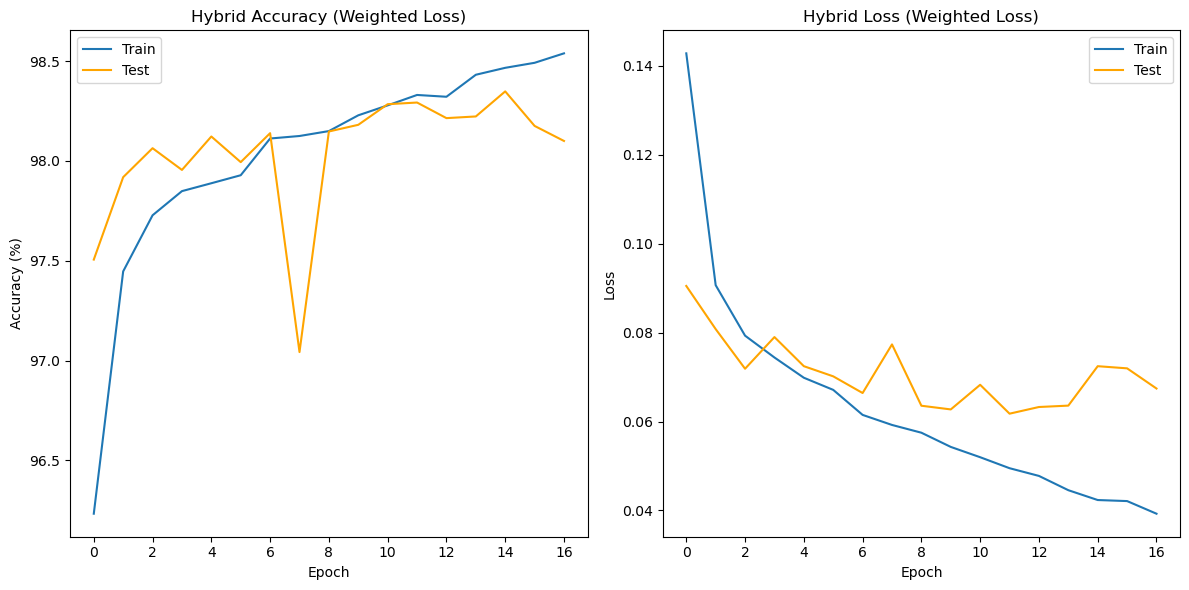

In [48]:
plt.figure(1, clear=True, figsize=[12, 6])

# Convert the accuracy and loss values to NumPy arrays
train_acc = np.array(scores_model_2['train_acc'])
test_acc = np.array(scores_model_2['test_acc'])

# For loss values, ensure they're on CPU before conversion
train_loss = np.array([loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in scores_model_2['train_loss']])
test_loss = np.array([loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in scores_model_2['test_loss']])

plt.subplot(1, 2, 1)
plt.plot(np.arange(0, max_epoch_2, 1), train_acc, label='Train')
plt.plot(np.arange(0,max_epoch_2,1), test_acc, color='orange', label='Test')
plt.title('Hybrid Accuracy (Weighted Loss)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig('Figures/model_2_acc.jpg')

plt.subplot(1, 2, 2)
plt.plot(np.arange(0, max_epoch_2, 1), train_loss, label='Train')
plt.plot(np.arange(0, max_epoch_2, 1), test_loss, color='orange', label='Test')
plt.title('Hybrid Loss (Weighted Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Figures/model_2_loss.jpg')

plt.tight_layout()
plt.show()


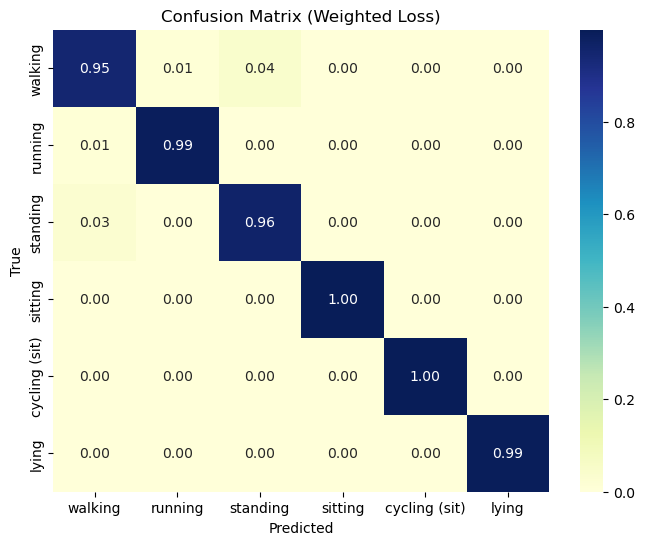

In [60]:
y_preds, y_true = hf.get_preds(model = model_2,
                            data_loader = test_loader,
                            device = device)

class_names = ['walking', 'running', 'standing', 'sitting', 'cycling (sit)','lying']

# Create confusion matrix
cm = confusion_matrix(y_true, y_preds, normalize='true')

# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Weighted Loss)')
plt.savefig('Figures/model_2_confm.jpg')

### Weighted Random Sampler

In [43]:
# Normalize to ensure weights sum to 1
label_weights = label_weights / label_weights.sum()

# Map each sample in the dataset to its corresponding weight based on its label
sample_weights = [0] * len(train_dataset)
for idx, (data, label) in enumerate(train_dataset):
    # Convert the label tensor to an integer for indexing
    class_weight = label_weights[label.item()]  # .item() converts tensor to scalar
    sample_weights[idx] = class_weight

# Set up the WeightedRandomSampler with these weights
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=int(len(train_dataset)), replacement=True)

In [44]:
# Create DataLoaders with new samplers
train_loader = DataLoader(train_dataset, sampler=sampler, batch_size=128)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

In [45]:
model_3 = HAR_Hybrid().to(device)
next(model_3.parameters()).device

device(type='cuda', index=0)

In [46]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3.parameters(), lr=0.001)

In [47]:
# Lists to store accuracy and loss values for future plotting
scores_model_3 = {'train_loss': [],
                  'train_acc': [],
                  'test_loss': [],
                  'test_acc': []}

# Set early stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0
max_epoch_3 = 0

# Initialize training time
train_time_start = timer()
epochs = 50

for epoch in tqdm(range(epochs)):
    print('Epoch: ', epoch, '\n---------------')
    max_epoch_3 += 1
    # Training step
    hf.train_step(
        model=model_3,
        data_loader=train_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=hf.accuracy_fn,
        device=device,
        scores_storage=scores_model_3
    )

    # Validation step
    val_loss = hf.test_step(
        model=model_3,
        data_loader=val_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=hf.accuracy_fn,
        device=device,
        scores_storage=scores_model_3
    )

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves
        print(f"Validation loss improved to {best_val_loss:.5f}, resetting patience counter.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss. Patience counter: {patience_counter}/{patience}")

    # Check if early stopping condition is met
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# End training time
train_time_end = timer()
total_train_time = train_time_end - train_time_start
print(f"Train time: {total_train_time:.3f} seconds")

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch:  0 
---------------
Train Loss: 0.13578	Train Accuracy: 96.13%


  2%|█▋                                                                                 | 1/50 [00:15<12:56, 15.85s/it]

Test Loss: 0.07945	Test Accuracy: 97.61%
Validation loss improved to 0.07945, resetting patience counter.
Epoch:  1 
---------------
Train Loss: 0.08354	Train Accuracy: 97.44%


  4%|███▎                                                                               | 2/50 [00:30<12:19, 15.41s/it]

Test Loss: 0.07111	Test Accuracy: 97.90%
Validation loss improved to 0.07111, resetting patience counter.
Epoch:  2 
---------------
Train Loss: 0.07524	Train Accuracy: 97.66%


  6%|████▉                                                                              | 3/50 [00:45<11:39, 14.88s/it]

Test Loss: 0.07338	Test Accuracy: 97.79%
No improvement in validation loss. Patience counter: 1/5
Epoch:  3 
---------------
Train Loss: 0.06983	Train Accuracy: 97.78%


  8%|██████▋                                                                            | 4/50 [00:59<11:07, 14.51s/it]

Test Loss: 0.07771	Test Accuracy: 97.67%
No improvement in validation loss. Patience counter: 2/5
Epoch:  4 
---------------
Train Loss: 0.06255	Train Accuracy: 98.03%


 10%|████████▎                                                                          | 5/50 [01:13<10:49, 14.44s/it]

Test Loss: 0.06448	Test Accuracy: 98.09%
Validation loss improved to 0.06448, resetting patience counter.
Epoch:  5 
---------------
Train Loss: 0.06101	Train Accuracy: 98.04%


 12%|█████████▉                                                                         | 6/50 [01:27<10:33, 14.39s/it]

Test Loss: 0.06296	Test Accuracy: 98.03%
Validation loss improved to 0.06296, resetting patience counter.
Epoch:  6 
---------------
Train Loss: 0.05677	Train Accuracy: 98.11%


 14%|███████████▌                                                                       | 7/50 [01:52<12:49, 17.89s/it]

Test Loss: 0.07012	Test Accuracy: 98.09%
No improvement in validation loss. Patience counter: 1/5
Epoch:  7 
---------------
Train Loss: 0.05197	Train Accuracy: 98.25%


 16%|█████████████▎                                                                     | 8/50 [02:10<12:32, 17.91s/it]

Test Loss: 0.06126	Test Accuracy: 98.20%
Validation loss improved to 0.06126, resetting patience counter.
Epoch:  8 
---------------
Train Loss: 0.04992	Train Accuracy: 98.35%


 18%|██████████████▉                                                                    | 9/50 [02:25<11:33, 16.91s/it]

Test Loss: 0.06072	Test Accuracy: 98.07%
Validation loss improved to 0.06072, resetting patience counter.
Epoch:  9 
---------------
Train Loss: 0.04717	Train Accuracy: 98.42%


 20%|████████████████▍                                                                 | 10/50 [02:39<10:44, 16.11s/it]

Test Loss: 0.06173	Test Accuracy: 98.22%
No improvement in validation loss. Patience counter: 1/5
Epoch:  10 
---------------
Train Loss: 0.04510	Train Accuracy: 98.47%


 22%|██████████████████                                                                | 11/50 [02:54<10:08, 15.61s/it]

Test Loss: 0.06136	Test Accuracy: 98.23%
No improvement in validation loss. Patience counter: 2/5
Epoch:  11 
---------------
Train Loss: 0.04275	Train Accuracy: 98.56%


 24%|███████████████████▋                                                              | 12/50 [03:08<09:42, 15.33s/it]

Test Loss: 0.06719	Test Accuracy: 98.15%
No improvement in validation loss. Patience counter: 3/5
Epoch:  12 
---------------
Train Loss: 0.04117	Train Accuracy: 98.62%


 26%|█████████████████████▎                                                            | 13/50 [03:23<09:19, 15.12s/it]

Test Loss: 0.06266	Test Accuracy: 98.22%
No improvement in validation loss. Patience counter: 4/5
Epoch:  13 
---------------
Train Loss: 0.03878	Train Accuracy: 98.68%


 26%|█████████████████████▎                                                            | 13/50 [03:38<10:20, 16.78s/it]

Test Loss: 0.06382	Test Accuracy: 98.21%
No improvement in validation loss. Patience counter: 5/5
Early stopping triggered after 14 epochs.
Train time: 218.148 seconds


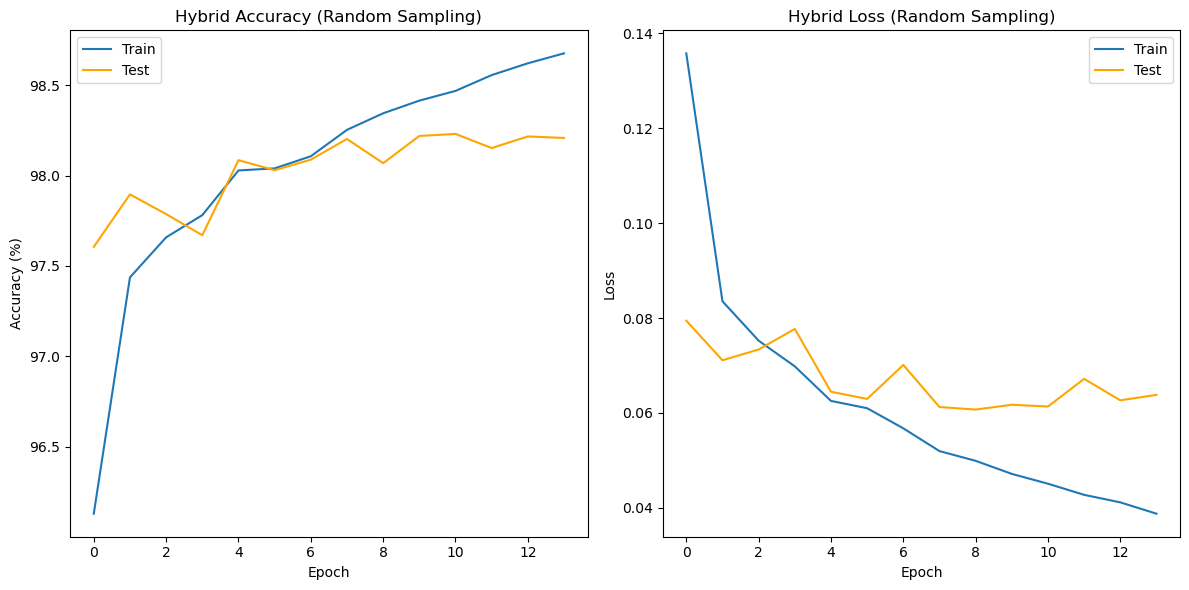

In [49]:
plt.figure(1, clear=True, figsize=[12, 6])

# Convert the accuracy and loss values to NumPy arrays
train_acc = np.array(scores_model_3['train_acc'])
test_acc = np.array(scores_model_3['test_acc'])

# For loss values, ensure they're on CPU before conversion
train_loss = np.array([loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in scores_model_3['train_loss']])
test_loss = np.array([loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in scores_model_3['test_loss']])

plt.subplot(1, 2, 1)
plt.plot(np.arange(0, max_epoch_3, 1), train_acc, label='Train')
plt.plot(np.arange(0,max_epoch_3,1), test_acc, color='orange', label='Test')
plt.title('Hybrid Accuracy (Random Sampling)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig('Figures/model_3_acc.jpg')

plt.subplot(1, 2, 2)
plt.plot(np.arange(0, max_epoch_3, 1), train_loss, label='Train')
plt.plot(np.arange(0, max_epoch_3, 1), test_loss, color='orange', label='Test')
plt.title('Hybrid Loss (Random Sampling)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Figures/model_3_loss.jpg')

plt.tight_layout()
plt.show()


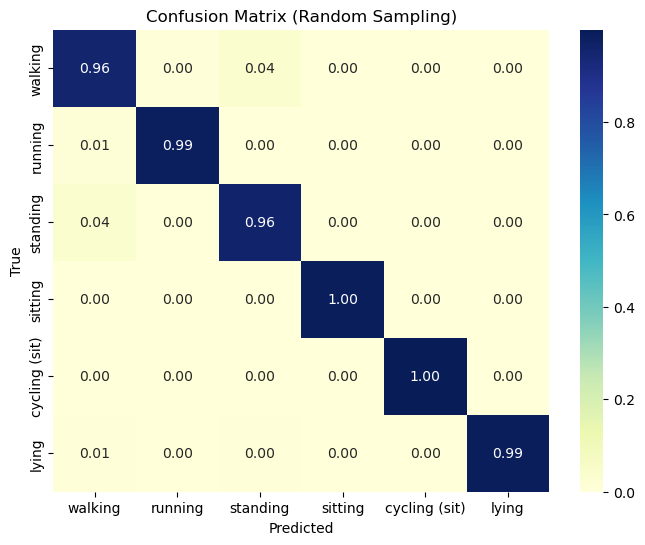

In [61]:
y_preds, y_true = hf.get_preds(model = model_3,
                            data_loader = test_loader,
                            device = device)

class_names = ['walking', 'running', 'standing', 'sitting', 'cycling (sit)','lying']

# Create confusion matrix
cm = confusion_matrix(y_true, y_preds, normalize='true')

# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Random Sampling)')
plt.savefig('Figures/model_3_confm.jpg')

### Manually Balancing Dataset

In [52]:
# Load raw data from CSVs
raw_data = pd.read_csv('processed_data/relabeled_data.csv')  # Adjust the path as needed

In [53]:
# Create windows and labels with 25-sample overlap
windows, labels = hf.create_windows(raw_data, sequence_length=50, overlap=25)

windows_df = pd.DataFrame({
    'features': windows,
    'label': labels
})

In [54]:
# Count label occurrences
label_counts = windows_df['label'].value_counts()
min_class_size = label_counts.min()

# Downsample larger classes
balanced_windows = []

for label in label_counts.index:
    class_windows = windows_df[windows_df['label'] == label]
    if len(class_windows) > min_class_size:
        # Randomly sample to downsample
        class_windows = class_windows.sample(n=min_class_size, random_state=42)
    balanced_windows.append(class_windows)

# Concatenate back to a single DataFrame
balanced_windows_df = pd.concat(balanced_windows)
label_counts = balanced_windows_df['label'].value_counts()
print(label_counts)

label
3    11649
0    11649
2    11649
4    11649
5    11649
1    11649
Name: count, dtype: int64


In [55]:
# Shuffle the DataFrame
balanced_windows_df = balanced_windows_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the dataset
train_df, temp_df = train_test_split(balanced_windows_df, train_size=0.7, stratify=balanced_windows_df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

In [56]:
model_4 = HAR_Hybrid().to(device)
next(model_4.parameters()).device

device(type='cuda', index=0)

In [57]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_4.parameters(), lr=0.001)

In [58]:
# Lists to store accuracy and loss values for future plotting
scores_model_4 = {'train_loss': [],
                  'train_acc': [],
                  'test_loss': [],
                  'test_acc': []}

# Set early stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0
max_epoch_4 = 0

# Initialize training time
train_time_start = timer()
epochs = 50

for epoch in tqdm(range(epochs)):
    print('Epoch: ', epoch, '\n---------------')
    max_epoch_4 += 1
    # Training step
    hf.train_step(
        model=model_4,
        data_loader=train_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=hf.accuracy_fn,
        device=device,
        scores_storage=scores_model_4
    )

    # Validation step
    val_loss = hf.test_step(
        model=model_4,
        data_loader=val_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=hf.accuracy_fn,
        device=device,
        scores_storage=scores_model_4
    )

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves
        print(f"Validation loss improved to {best_val_loss:.5f}, resetting patience counter.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss. Patience counter: {patience_counter}/{patience}")

    # Check if early stopping condition is met
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# End training time
train_time_end = timer()
total_train_time = train_time_end - train_time_start
print(f"Train time: {total_train_time:.3f} seconds")

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch:  0 
---------------
Train Loss: 0.13350	Train Accuracy: 96.12%


  2%|█▋                                                                                 | 1/50 [00:14<11:57, 14.64s/it]

Test Loss: 0.07866	Test Accuracy: 97.74%
Validation loss improved to 0.07866, resetting patience counter.
Epoch:  1 
---------------
Train Loss: 0.08600	Train Accuracy: 97.39%


  4%|███▎                                                                               | 2/50 [00:28<11:31, 14.41s/it]

Test Loss: 0.07540	Test Accuracy: 97.88%
Validation loss improved to 0.07540, resetting patience counter.
Epoch:  2 
---------------
Train Loss: 0.07988	Train Accuracy: 97.55%


  6%|████▉                                                                              | 3/50 [00:43<11:18, 14.43s/it]

Test Loss: 0.07067	Test Accuracy: 97.87%
Validation loss improved to 0.07067, resetting patience counter.
Epoch:  3 
---------------
Train Loss: 0.07079	Train Accuracy: 97.75%


  8%|██████▋                                                                            | 4/50 [00:56<10:46, 14.06s/it]

Test Loss: 0.06897	Test Accuracy: 97.94%
Validation loss improved to 0.06897, resetting patience counter.
Epoch:  4 
---------------
Train Loss: 0.06410	Train Accuracy: 97.92%


 10%|████████▎                                                                          | 5/50 [01:10<10:23, 13.86s/it]

Test Loss: 0.06784	Test Accuracy: 97.98%
Validation loss improved to 0.06784, resetting patience counter.
Epoch:  5 
---------------
Train Loss: 0.06330	Train Accuracy: 97.91%


 12%|█████████▉                                                                         | 6/50 [01:24<10:07, 13.80s/it]

Test Loss: 0.06326	Test Accuracy: 98.06%
Validation loss improved to 0.06326, resetting patience counter.
Epoch:  6 
---------------
Train Loss: 0.05462	Train Accuracy: 98.23%


 14%|███████████▌                                                                       | 7/50 [01:37<09:51, 13.76s/it]

Test Loss: 0.06055	Test Accuracy: 98.14%
Validation loss improved to 0.06055, resetting patience counter.
Epoch:  7 
---------------
Train Loss: 0.05345	Train Accuracy: 98.26%


 16%|█████████████▎                                                                     | 8/50 [01:51<09:34, 13.67s/it]

Test Loss: 0.06381	Test Accuracy: 97.87%
No improvement in validation loss. Patience counter: 1/5
Epoch:  8 
---------------
Train Loss: 0.04985	Train Accuracy: 98.38%


 18%|██████████████▉                                                                    | 9/50 [02:04<09:12, 13.49s/it]

Test Loss: 0.06007	Test Accuracy: 98.15%
Validation loss improved to 0.06007, resetting patience counter.
Epoch:  9 
---------------
Train Loss: 0.04793	Train Accuracy: 98.39%


 20%|████████████████▍                                                                 | 10/50 [02:17<08:54, 13.36s/it]

Test Loss: 0.06282	Test Accuracy: 98.18%
No improvement in validation loss. Patience counter: 1/5
Epoch:  10 
---------------
Train Loss: 0.04555	Train Accuracy: 98.43%


 22%|██████████████████                                                                | 11/50 [02:30<08:41, 13.36s/it]

Test Loss: 0.06309	Test Accuracy: 98.15%
No improvement in validation loss. Patience counter: 2/5
Epoch:  11 
---------------
Train Loss: 0.04264	Train Accuracy: 98.57%


 24%|███████████████████▋                                                              | 12/50 [02:44<08:30, 13.42s/it]

Test Loss: 0.06395	Test Accuracy: 98.12%
No improvement in validation loss. Patience counter: 3/5
Epoch:  12 
---------------
Train Loss: 0.03893	Train Accuracy: 98.69%


 26%|█████████████████████▎                                                            | 13/50 [02:57<08:14, 13.37s/it]

Test Loss: 0.06501	Test Accuracy: 98.16%
No improvement in validation loss. Patience counter: 4/5
Epoch:  13 
---------------
Train Loss: 0.03856	Train Accuracy: 98.66%


 26%|█████████████████████▎                                                            | 13/50 [03:10<09:02, 14.66s/it]

Test Loss: 0.06226	Test Accuracy: 98.24%
No improvement in validation loss. Patience counter: 5/5
Early stopping triggered after 14 epochs.
Train time: 190.645 seconds


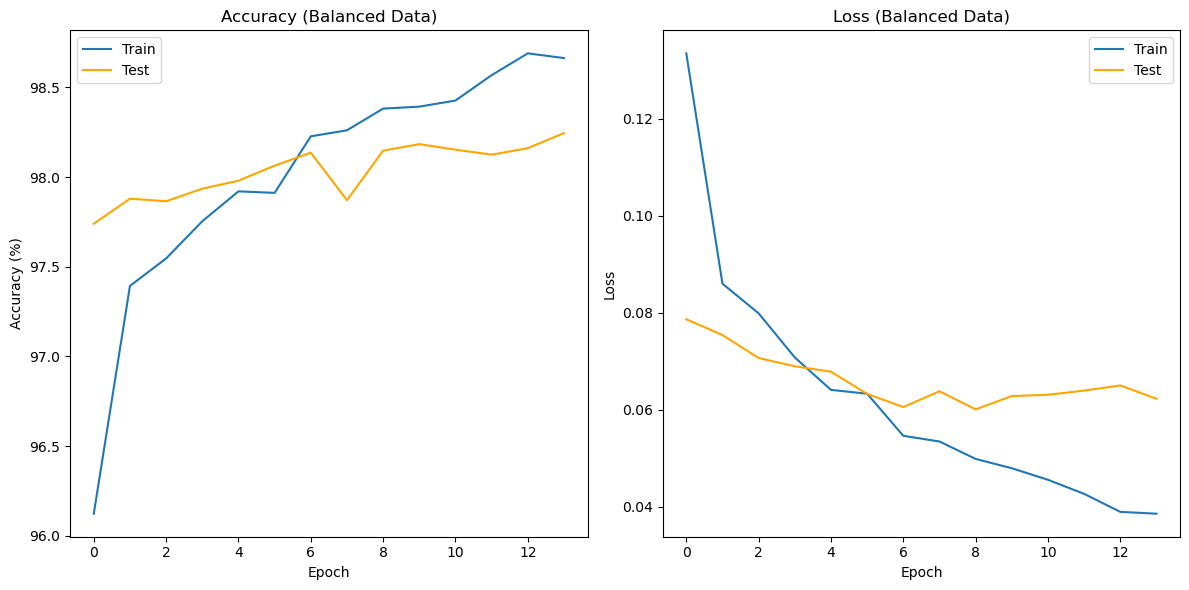

In [62]:
plt.figure(1, clear=True, figsize=[12, 6])

# Convert the accuracy and loss values to NumPy arrays
train_acc = np.array(scores_model_4['train_acc'])
test_acc = np.array(scores_model_4['test_acc'])

# For loss values, ensure they're on CPU before conversion
train_loss = np.array([loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in scores_model_4['train_loss']])
test_loss = np.array([loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in scores_model_4['test_loss']])

plt.subplot(1, 2, 1)
plt.plot(np.arange(0, max_epoch_4, 1), train_acc, label='Train')
plt.plot(np.arange(0,max_epoch_4,1), test_acc, color='orange', label='Test')
plt.title('Accuracy (Balanced Data)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig('Figures/model_4_acc.jpg')

plt.subplot(1, 2, 2)
plt.plot(np.arange(0, max_epoch_4, 1), train_loss, label='Train')
plt.plot(np.arange(0, max_epoch_4, 1), test_loss, color='orange', label='Test')
plt.title('Loss (Balanced Data)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Figures/model_4_loss.jpg')

plt.tight_layout()
plt.show()


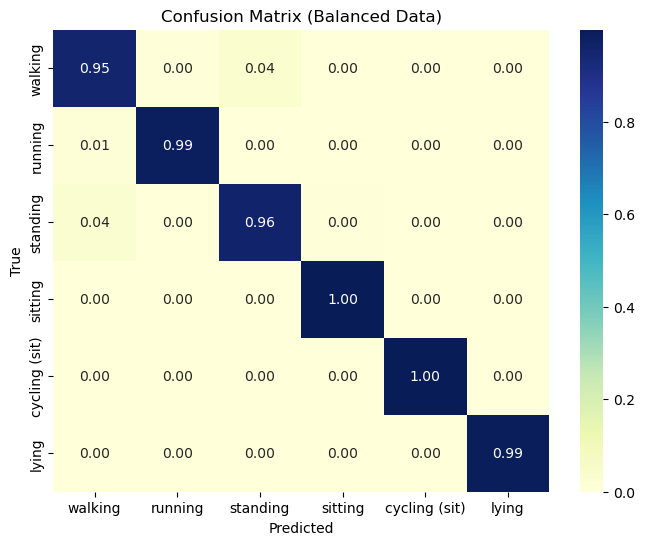

In [64]:
y_preds, y_true = hf.get_preds(model = model_4,
                            data_loader = test_loader,
                            device = device)

class_names = ['walking', 'running', 'standing', 'sitting', 'cycling (sit)','lying']

# Create confusion matrix
cm = confusion_matrix(y_true, y_preds, normalize='true')

# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Balanced Data)')
plt.savefig('Figures/model_4_confm.jpg')

### Balancing Results
Unfortunately, the balancing methods did not lead to increases in performance, leading us to believe that any performance increases must be saught elsewhere. Some additional ideas to improve model performance include: hyperparameter optimization, raw signal filtering, experimenting with additional architectures, and different windowing techniques.

### Comparing results to existing literature
The two confusion matrices shown above are taken from two papers published by the creators of the HARTH dataset in order to compare my results to those of an academic lab. The matrix on the left was generated after an extensive feature engineering process and XGBoost classification. The two matrices on the right were generated using an XGBoost classifier and a one dimensional convolutional neural network. For these two models hyperparamter optimization is detailed, however feature engineering and filtering processes are not. The details of the papers' models and preprocessing strategies are described in greater detail in their respective papers. 